# 2. Develop roadmap construction methods

All the roadmap construction methods implemented in JAXMAPP are a subclass of `jaxmapp.roadmap.sampler.DefaultSampler`.

`DefaultSampler` has a function `construct_trms` that converts vertices and edges to a set of `TimedRoadmap`s. `TimedRoadmap` is a roadmap extended into the time direction (i.e., each vertex has its location + timestep) and used by our prioritized planning implementation to derive a solution. 

To develop your own roadmap construction methods, what you have to do is basically implementing your own version of `DefaultSampler.build_sample_vertices`.
This function will be called when the sampler is instantiated, and returns a callable `sample_vertices` function that takes `key`, `num_samples`, and `instance` as input to provide vertices. 

For example, let's see how `RandomSampler` is implemented in `jaxmapp.roadmap.random_sampler.py`:

```python
@dataclass
class RandomSampler(DefaultSampler):
    """Random sampler"""

    def build_sample_vertices(self):

        if self.share_roadmap:

            def sample_vertices(key, num_samples, instance) -> Array:
                return sample_random_pos(
                    key, num_samples, instance.rads[0], instance.obs.sdf
                )

            return jax.jit(sample_vertices, static_argnames={"num_samples"})
        else:

            def sample_vertices(key, num_samples, instance) -> Array:
                keys = jax.random.split(key, instance.num_agents)
                return jax.jit(
                    jax.vmap(sample_random_pos, in_axes=(0, None, 0, None)),
                    static_argnames={"num_samples"},
                )(keys, num_samples, instance.rads, instance.obs.sdf)

            return sample_vertices
```

Here is one important attribute named `share_roadmap`, which tells the sampler how roadmaps should be constructed.

- If `share_roadmap == True`, all the agents will share the same roadmap while asssuming that they have the same `max_speed` (maximum speed of agents) and `rad` (size of agents). For this case, `build_sample_vertices` should return a function `sample_vertices` that outputs vertices with the shape `(num_samples, 2)`.
- If `share_roadmap == False`, agents will be supposed to follow their own roadmap, which is useful when they each have different speed and size. For this case, the output of `sample_vertices` should take the shape of `(num_agents, num_samples, 2)`.
- You could simply implement these two versions separately, or if you are familiar with `jax.vmap`, you can vectorize the function used for the `share_roadmap == True` efficiently.

As a more practical example, let's implement an adaptive version of random sampler that limits sampling regions to be rectangles defined by the start and goal positions of agents.

In [1]:
import jax
import jax.numpy as jnp
from chex import dataclass

from jaxmapp.roadmap.sampler import DefaultSampler
from jaxmapp.utils.sampler import sample_random_pos

@dataclass
class AdaptiveRandomSampler(DefaultSampler):
    share_roadmap:bool = False
    
    def build_sample_vertices(self):
        def sample_vertices_from_rectangle(key, num_samples, rad, sdf, start, goal):
            """ Sample vertices from the rectanglar region defined by start and goal """
            
            vertices = sample_random_pos(key, num_samples, rad, jnp.ones(sdf.shape))
            start_goal = jnp.vstack((start, goal))
            top_left = start_goal.min(axis=0) * 0.9
            bottom_right = start_goal.max(axis=0) * 1.1
            return vertices * (bottom_right - top_left) + top_left
        
        if self.share_roadmap:
            raise NotImplementedError()
        else:
            keys = jax.random.split(key, ins.num_agents)
            vmapped_fn = jax.vmap(jax.jit(sample_vertices_from_rectangle, static_argnames={"num_samples"}), in_axes=(0, None, 0, None, 0, 0))
            return lambda key, num_samples, ins: vmapped_fn(keys, num_samples, ins.rads, ins.obs.sdf, ins.starts, ins.goals)
        

2022-10-11 12:39:08.708998: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-11 12:39:09.067124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-11 12:39:09.067205: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-11 12:39:09.067211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Note that although the implementation above is based on jax, you can essentially use any language as long as the input and output have the expected shape.

res_adaptive=Status: solved, makespan: 26.00, sum-of-costs: 193.00, sum-of-costs (normed): 19.30
res_random=Status: solved, makespan: 39.00, sum-of-costs: 252.00, sum-of-costs (normed): 25.20


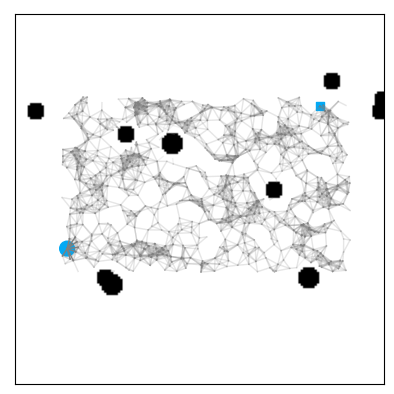

In [2]:
import jax 
from jaxmapp.env import InstanceGeneratorCircleObs
from jaxmapp.roadmap import RandomSampler
from jaxmapp.planner import PrioritizedPlanning
from jaxmapp.utils import viz

key = jax.random.PRNGKey(46)
generator = InstanceGeneratorCircleObs(num_agents_min=10, num_agents_max=10, 
                                        max_speeds_cands=[0.04], rads_cands=[0.02],
                                        map_size=160, num_obs=10)
ins = generator.generate(key)

# Aadaptive random sampler (with fewer vertices)
adaptive_sampler = AdaptiveRandomSampler(num_samples=800, max_T=64)
trms_adaptive = adaptive_sampler.construct_trms(key, ins)
viz.plot_trms(ins, trms_adaptive)

# Random sampler
random_sampler = RandomSampler(num_samples=1600, max_T=64, share_roadmap=True)
trms_random = random_sampler.construct_trms(key, ins)

planner = PrioritizedPlanning()
res_adaptive = planner.solve(ins.to_numpy(), trms_adaptive)
res_random = planner.solve(ins.to_numpy(), trms_random)
print(f"{res_adaptive=}")
print(f"{res_random=}")

## Advanced: Constructing timed roadmaps from timed vertices and edges

`GridSampler` and `RandomSampler` both generate vertices and edges that are 'non-timed', i.e., they assume vertices and edges to be fixed over timesteps.

Additionally, `DefaultSampler` allows its subclasses to generate 'timed' vertices and edges that vary over timesteps, which is what `CTRMSampler` is doing. To use timed vertices and edges, you'll need to:

- set `share_roadmap == False`
- set `timed_roadmap == True`
- define `build_sample_vertices` to return a callable function `sample_vertices` that takes `key` and `instance` as input to provide timed vertices with the shape `(num_agents, max_T, num_samples, 2)`, where `max_T` is the maximum timesteps.

As a specific example, let's further extend the above `AdaptiveRamdomSampler` to sample vertices from rectangles that moves from the start to the goal.

In [3]:
import jax
import jax.numpy as jnp
from chex import dataclass

from jaxmapp.roadmap.sampler import DefaultSampler
from jaxmapp.utils.sampler import sample_random_pos

@dataclass
class AdaptiveTimedRandomSampler(DefaultSampler):
    share_roadmap:bool = False
    timed_roadmap:bool = True
    
    def build_sample_vertices(self):
        def _sample_timed_vertices_from_rectangle(key, num_samples, rad, sdf, start, goal, max_T, t):
            vertices = sample_random_pos(key, num_samples, rad, jnp.ones(sdf.shape))
            return (vertices - 0.5) * 0.1 + start + (t / max_T) * (goal - start)

        def sample_timed_vertices_from_rectangle(key, num_samples, rad, sdf, start, goal):
            vertices = jax.vmap(_sample_timed_vertices_from_rectangle, in_axes=(None, None, None, None, None, None, None, 0))(key, num_samples, rad, sdf, start, goal, self.max_T, jnp.arange(self.max_T))
            return vertices
        
        if self.share_roadmap:
            raise NotImplementedError()
        else:
            vmapped_fn = jax.vmap(jax.jit(sample_timed_vertices_from_rectangle, static_argnames={"num_samples"}), in_axes=(None, None, 0, None, 0, 0))
            return lambda key, num_samples, ins: vmapped_fn(key, num_samples, ins.rads, ins.obs.sdf, ins.starts, ins.goals)
        

In [4]:
adaptive_timed_sampler = AdaptiveTimedRandomSampler(num_samples=50, max_T=64)
trms_adaptive_timed = adaptive_timed_sampler.construct_trms(key, ins)
planner = PrioritizedPlanning()
res_adaptive_timed = planner.solve(ins.to_numpy(), trms_adaptive_timed)
print(f"{res_adaptive_timed=}")

res_adaptive_timed=Status: solved, makespan: 61.00, sum-of-costs: 553.00, sum-of-costs (normed): 55.30


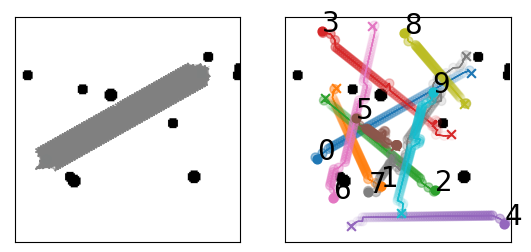

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2)
viz.plot_trms(ins, trms_adaptive_timed, is_timed=True, ax=axes[0])
viz.simple_plot_2d(ins, res_adaptive_timed, ax=axes[1])